# 은행 고객 세분화

- 고객의 특성 파악
- 탐색적 분석
- 결측치 처리
- 데이터 변환
- 클러스터링
- PCA 분석

# 데이터
## import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
# plt.rcParams['figure.figsize'] = (8,6)

%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.decomposition import PCA 
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# 데이터 다운로드
!curl -L https://bit.ly/2nnKpzH -o german_credit_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   151  100   151    0     0    674      0 --:--:-- --:--:-- --:--:--   674
100    68    0    68    0     0     86      0 --:--:-- --:--:-- --:--:--    86
100   297  100   297    0     0    216      0  0:00:01  0:00:01 --:--:--     0
100 49689  100 49689    0     0  27256      0  0:00:01  0:00:01 --:--:-- 27256


In [4]:
df = pd.read_csv('german_credit_data.csv')
print(df.shape)
df[:5]

(1000, 10)


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


- 첫번째 컬럼 삭제 

In [5]:
df = df.drop(['Unnamed: 0'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


# 탐색적 분석

In [6]:
# 컬럼별 가짓수
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64

In [7]:
# 연속변수 통계치 보기
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [8]:
# 카테고리 변수 통계
df.describe(include=object)

,Sex,Housing,Saving accounts,Checking account,Purpose
count,1000,1000,817,606,1000
unique,2,3,4,3,8
top,male,own,little,little,car
freq,690,713,603,274,337


In [9]:
# 모든 카테고리 변수의 내용을 본다
for col in df.select_dtypes(include=object):
    print(col,":\n", df[col].unique())

Sex :
 ['male' 'female']
Housing :
 ['own' 'free' 'rent']
Saving accounts :
 [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account :
 ['little' 'moderate' nan 'rich']
Purpose :
 ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


In [10]:
# 카테고리형, 연속형 변수 (컬럼명) 나누기
category_cols = df.select_dtypes(include=object).columns.tolist()
continuous_cols = df.select_dtypes(include=[int, float]).columns.tolist()

category_cols, continuous_cols

(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'],
 ['Age', 'Job', 'Credit amount', 'Duration'])

In [11]:
# Job은 숫자지만 카테고리 변수이므로 위치를 바꾼다
category_cols.append('Job')
continuous_cols.remove('Job')
# 확인하기
category_cols, continuous_cols

(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Job'],
 ['Age', 'Credit amount', 'Duration'])

## 분포 보기
- 연속 변수

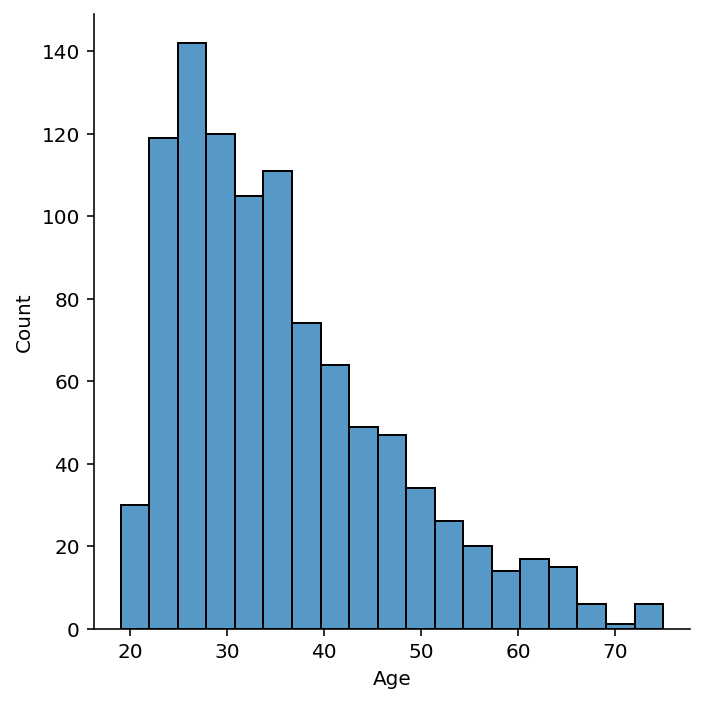

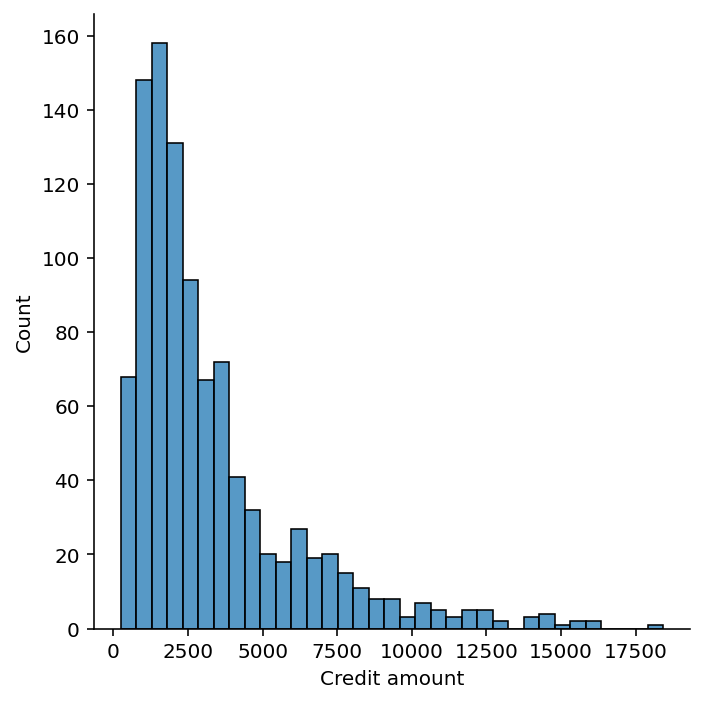

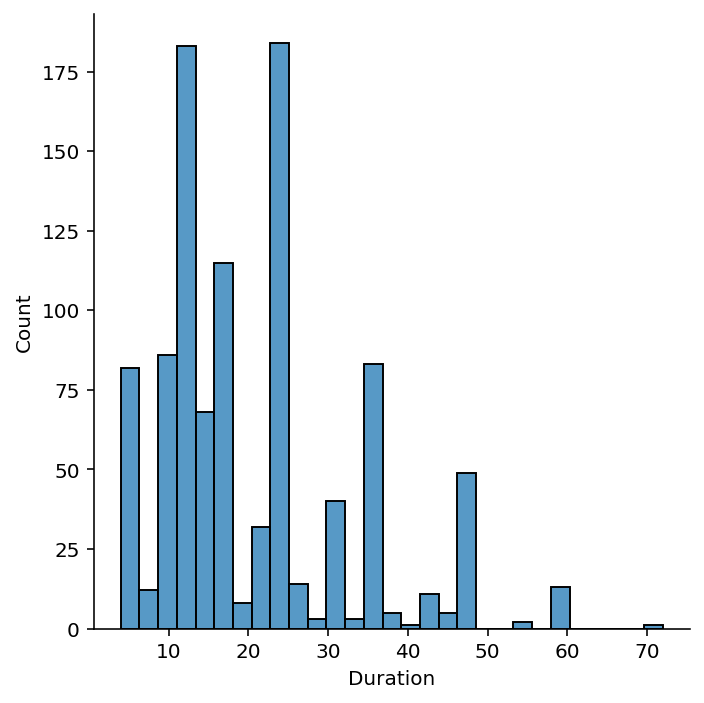

In [12]:
for col in continuous_cols:
    sns.displot(df[col])

- 카테고리 변수

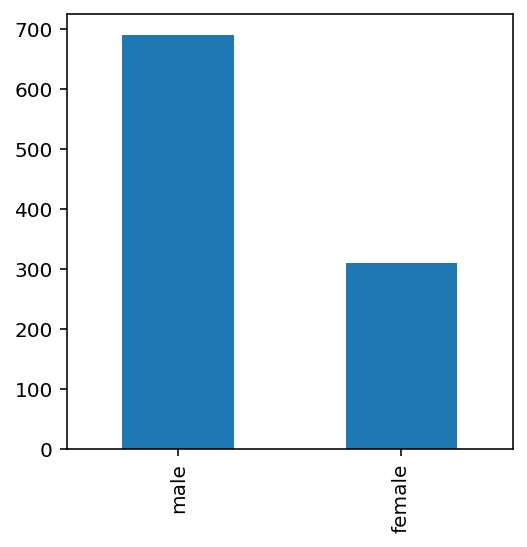

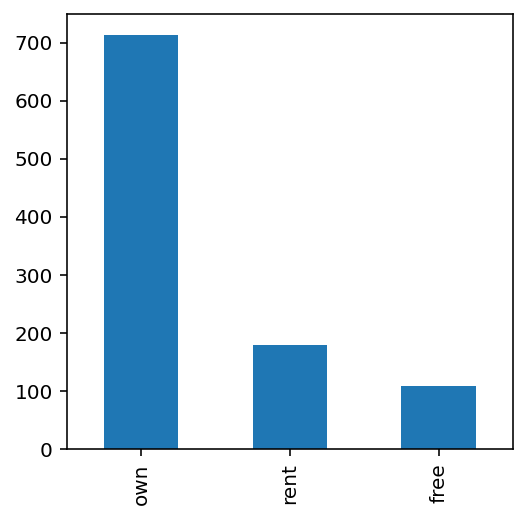

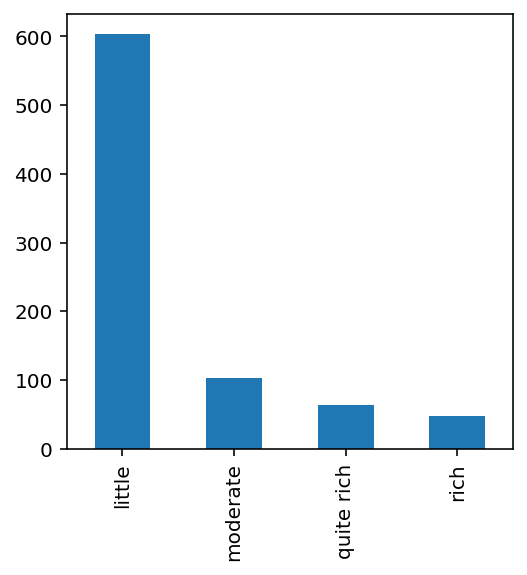

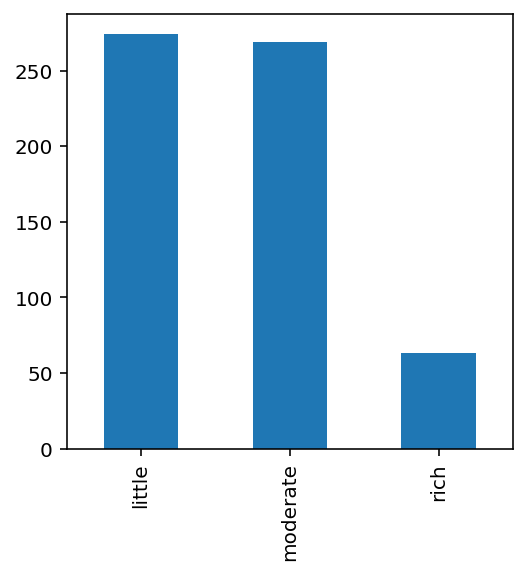

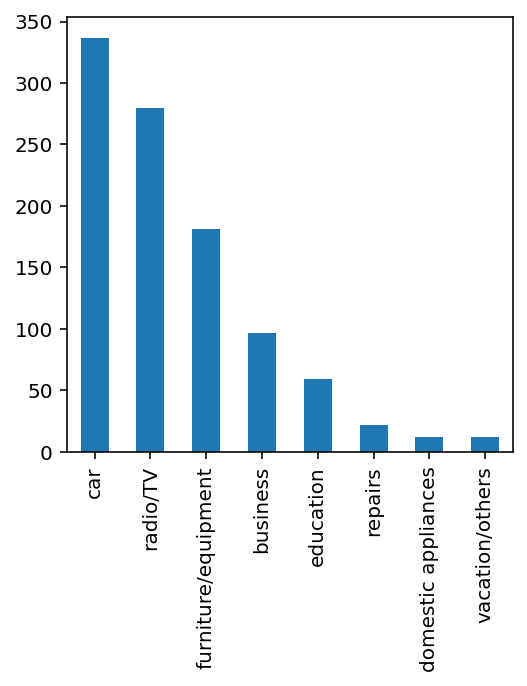

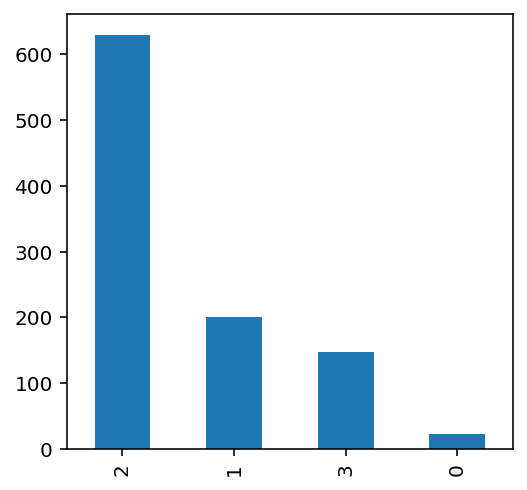

In [13]:
for col in category_cols:
    df[col].value_counts().plot(kind='bar',figsize=(4,4))
    plt.show()

## 산포도

In [14]:
scatter_list = list(itertools.combinations(continuous_cols, 2))
scatter_list

[('Age', 'Credit amount'), ('Age', 'Duration'), ('Credit amount', 'Duration')]

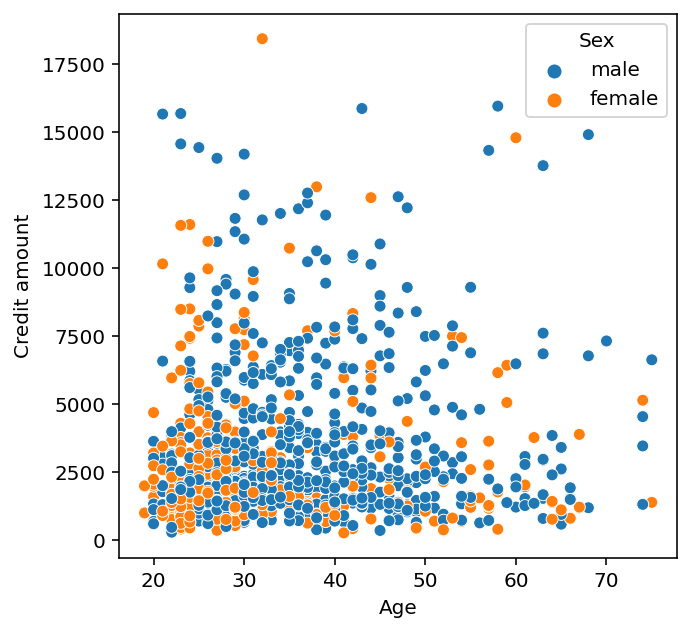

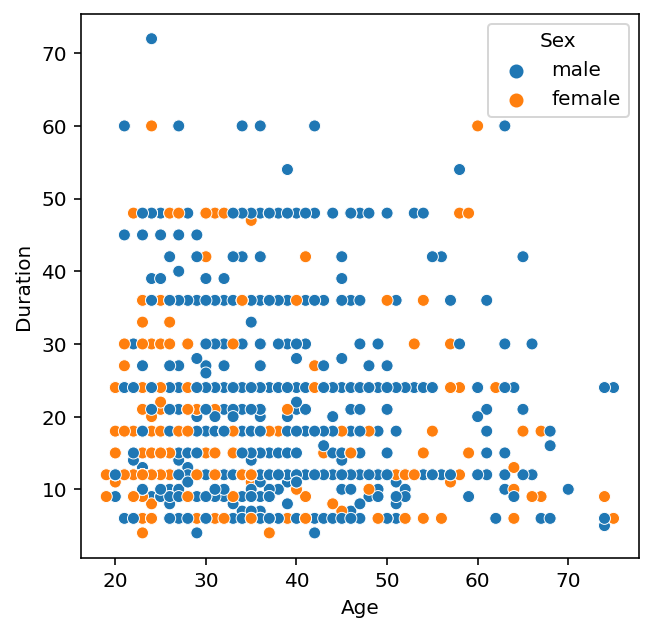

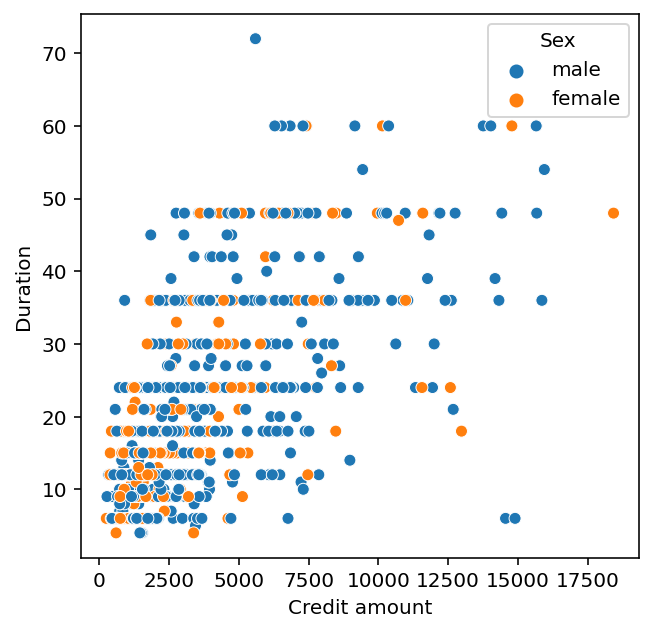

In [15]:
for pair in scatter_list:
    plt.figure(figsize=(5,5))
    sns.scatterplot(data=df, x=pair[0],y=pair[1],hue='Sex')
    plt.show()

## 박스플롯
- 각 연속변수의 범위를 각 카테고리별로 나누어 본다
- 남여를 구분해서 본다

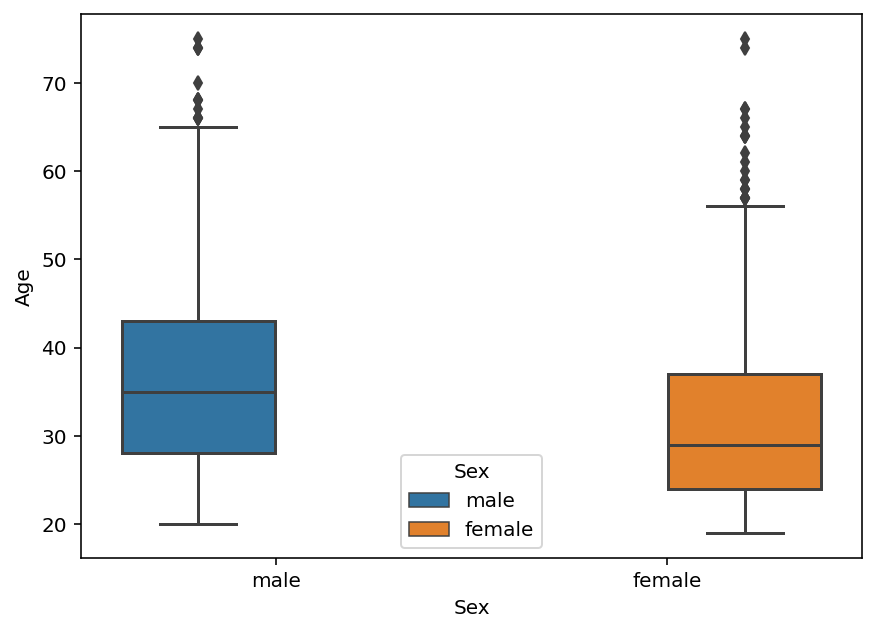

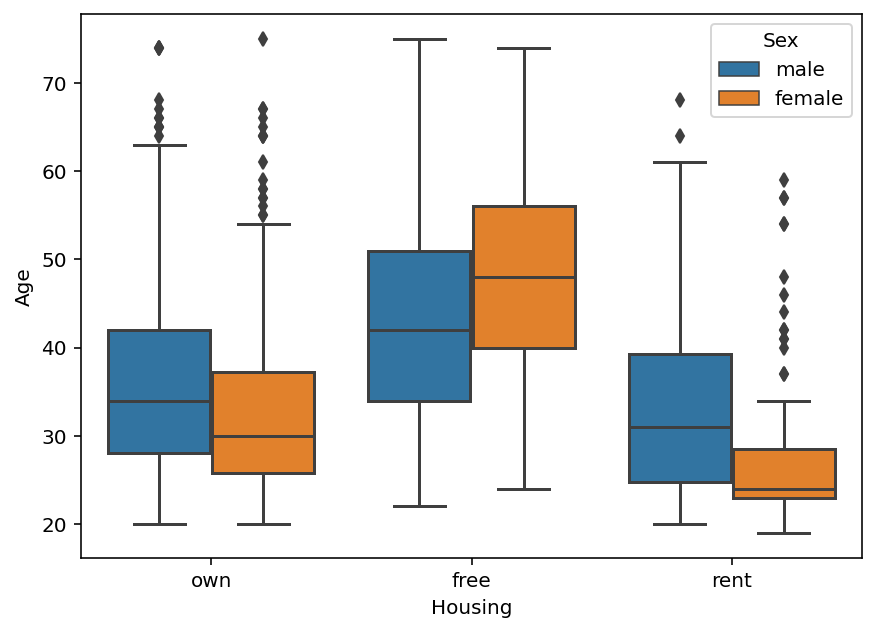

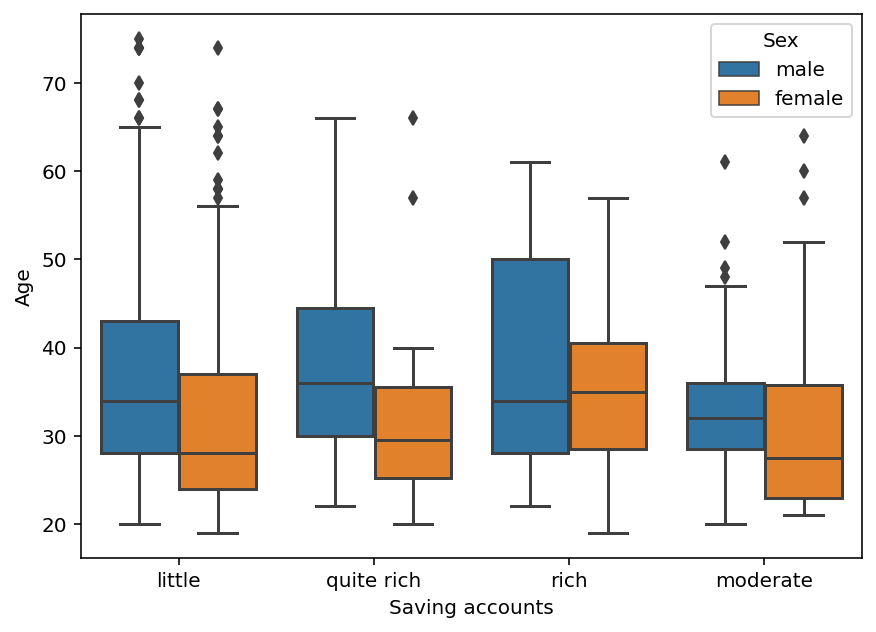

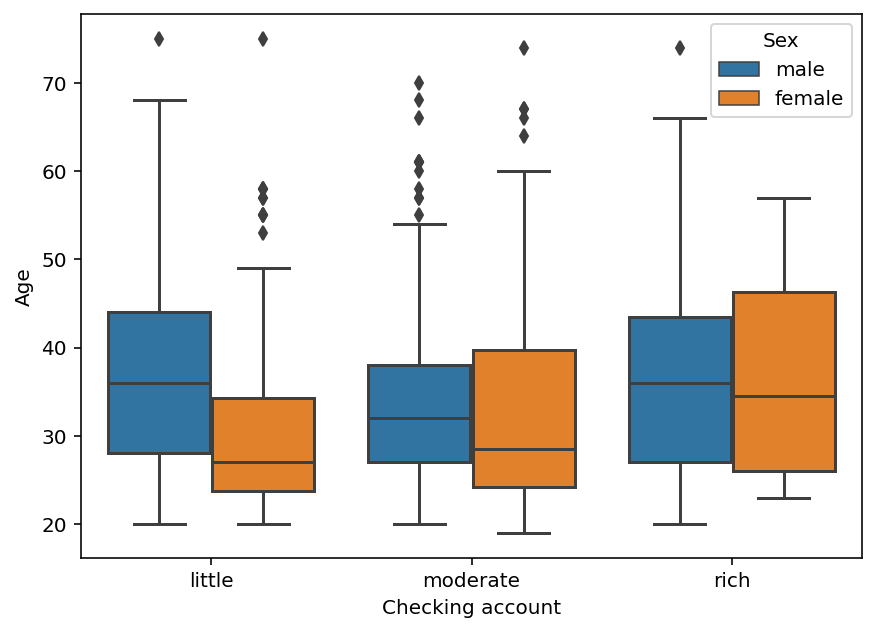

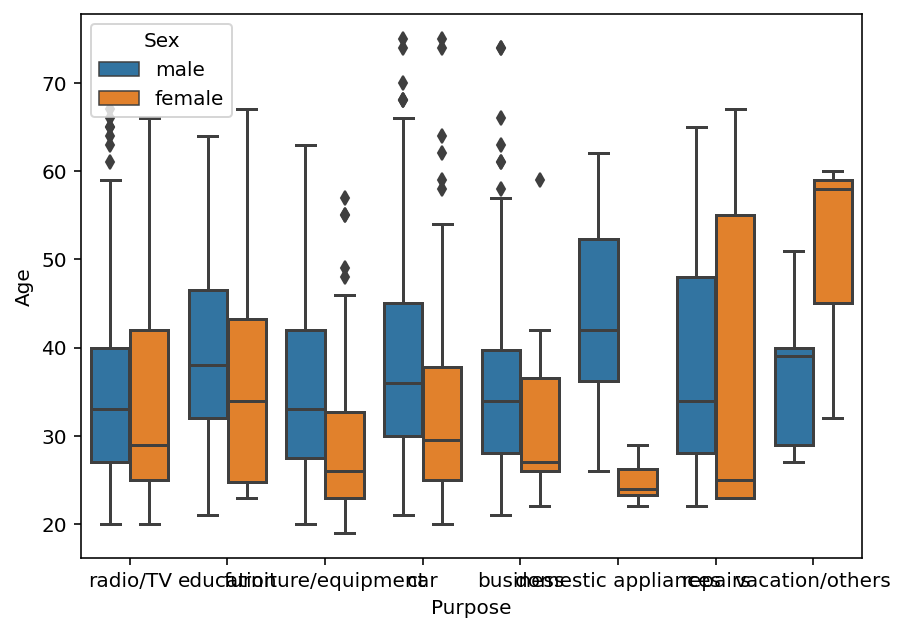

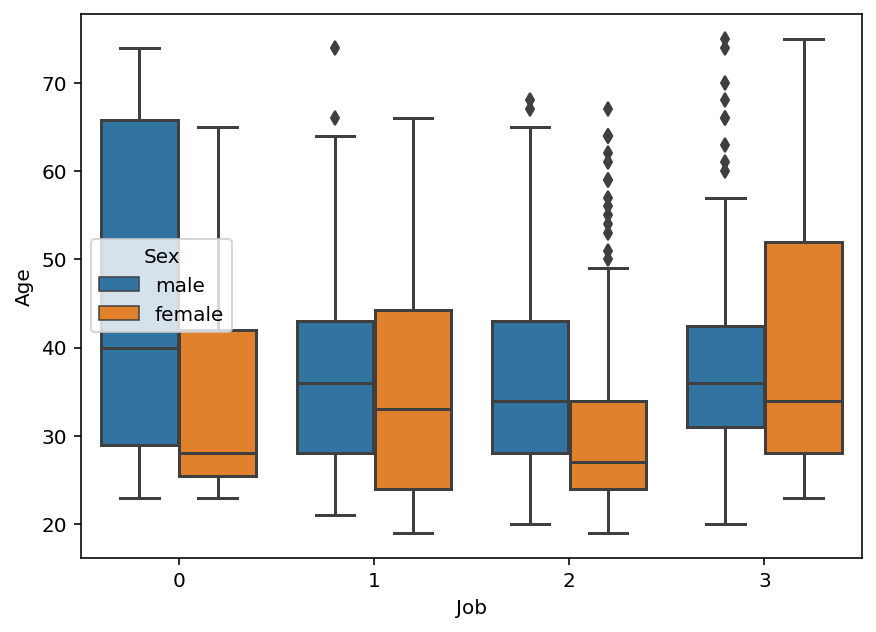

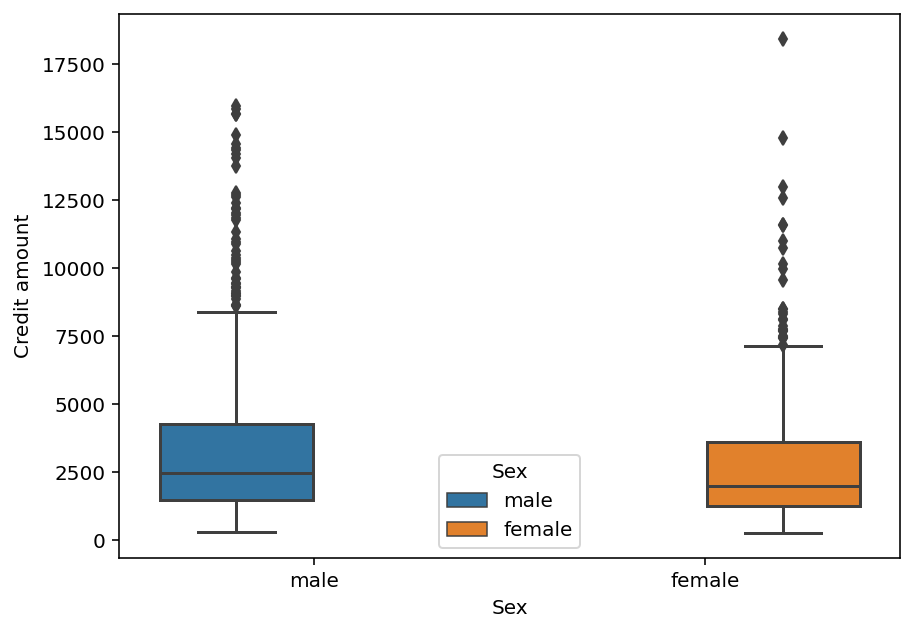

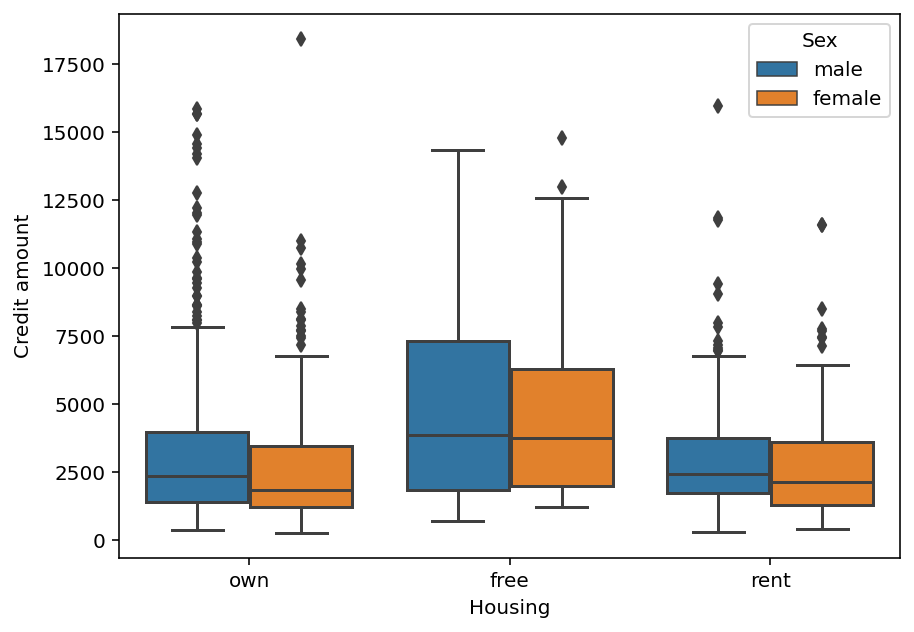

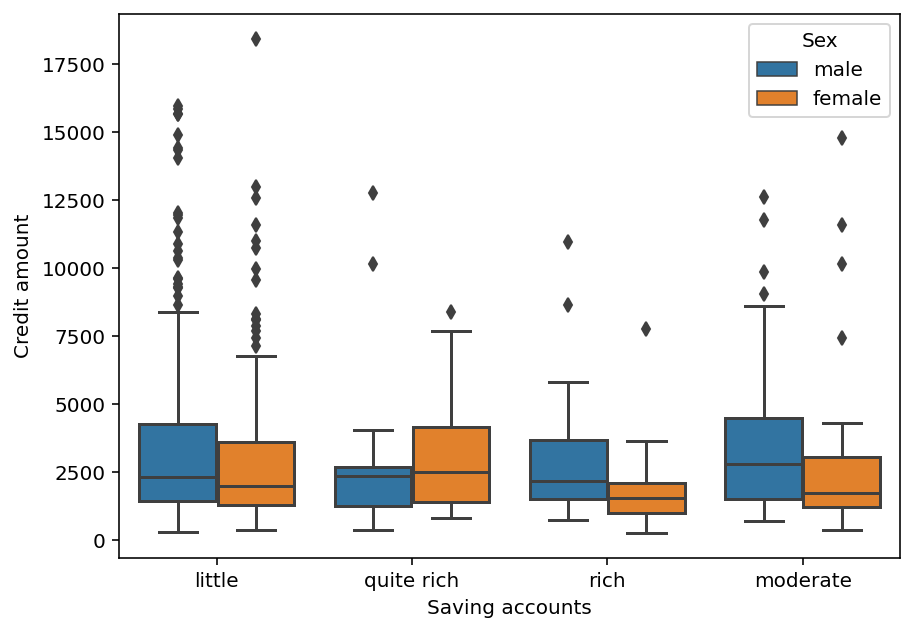

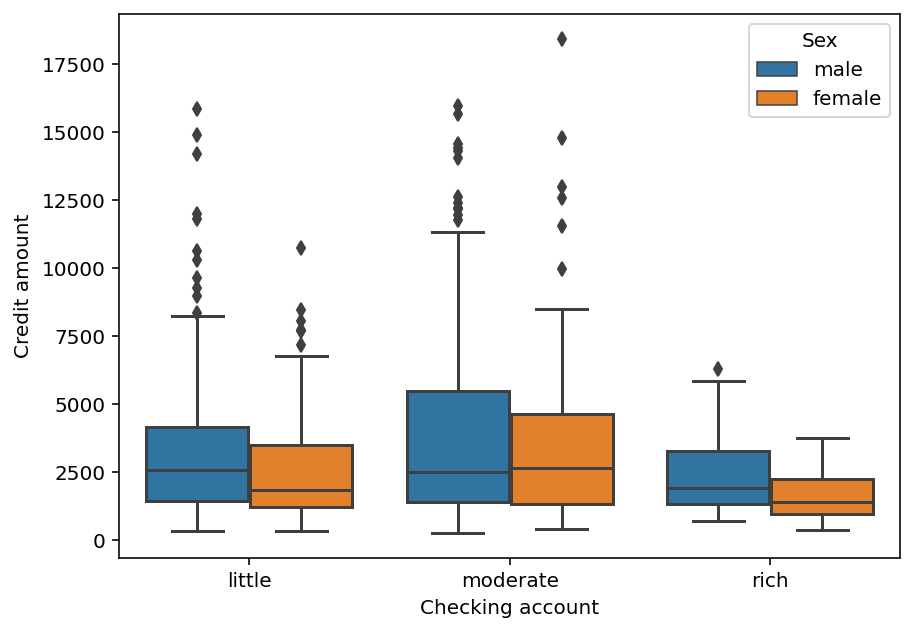

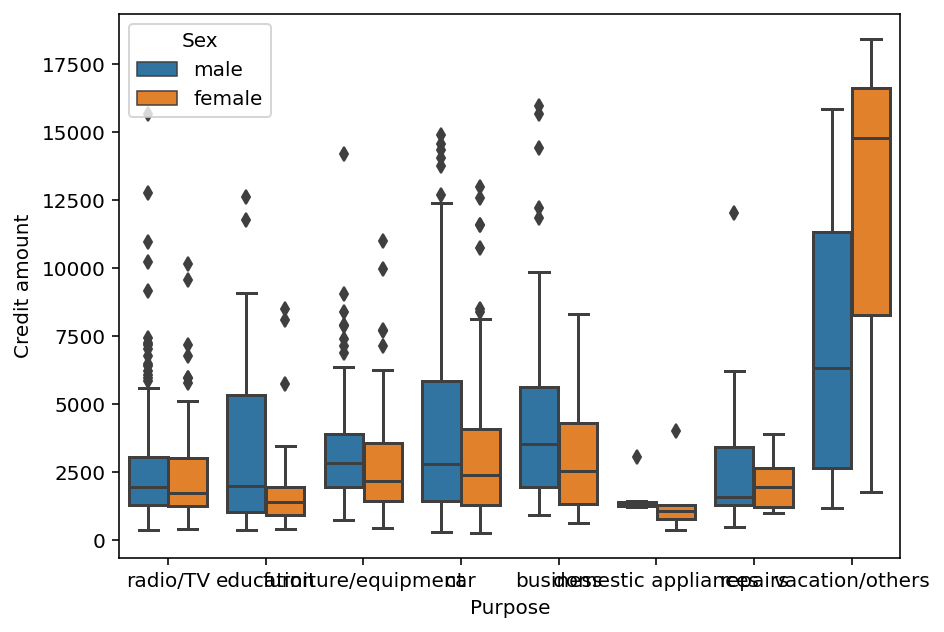

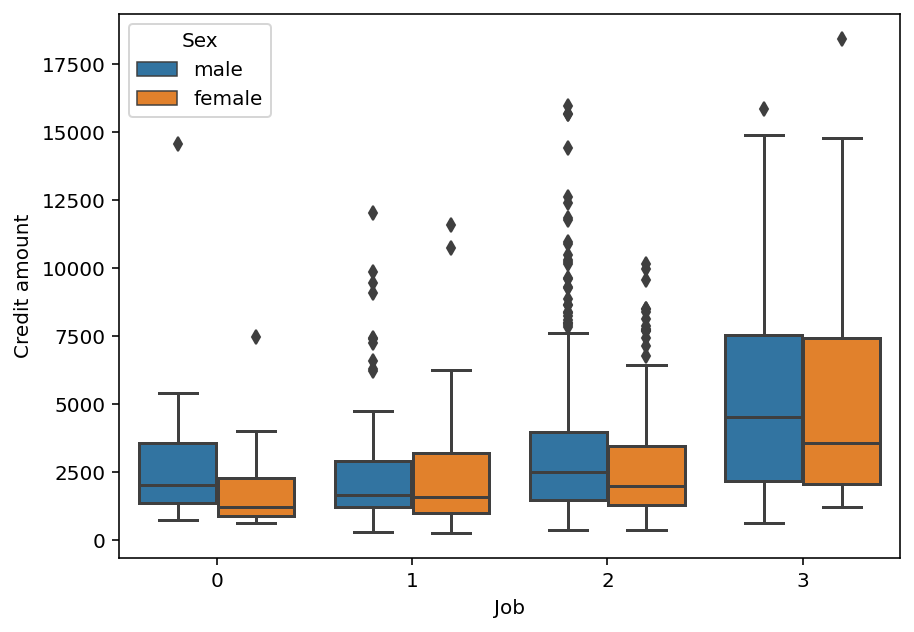

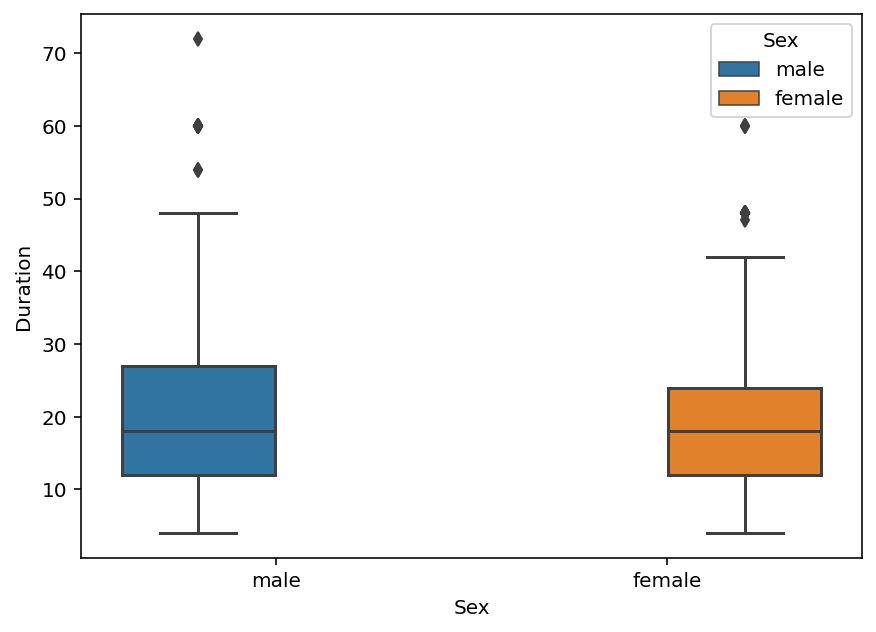

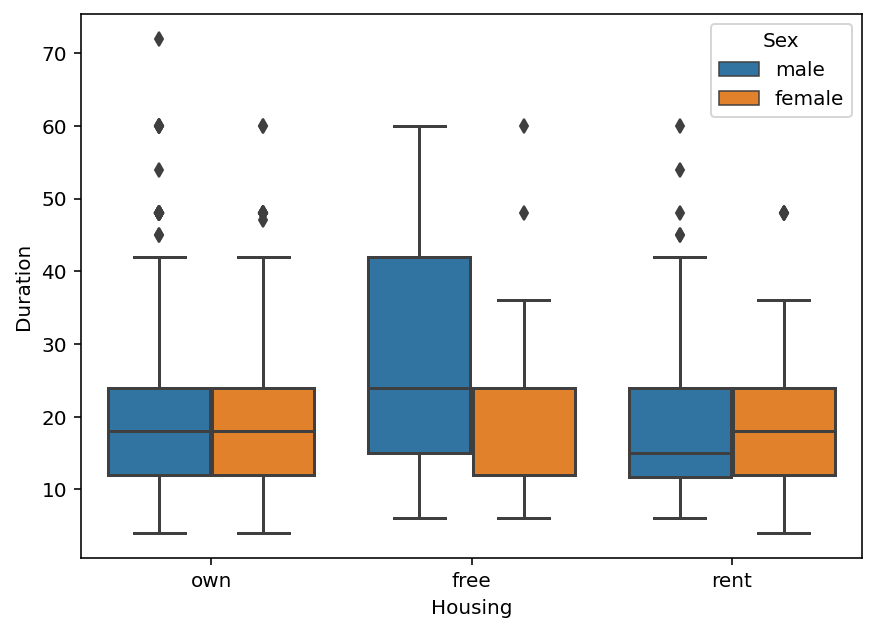

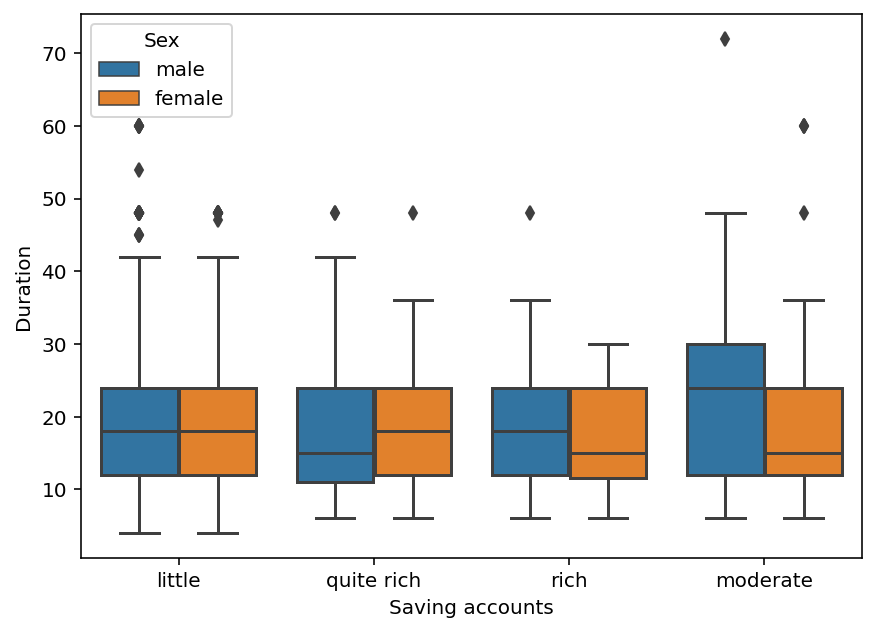

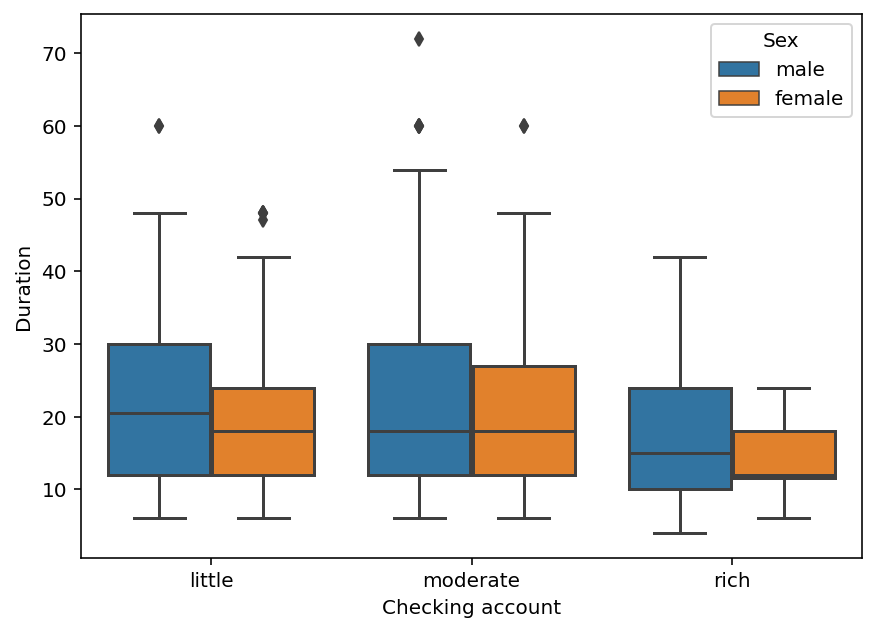

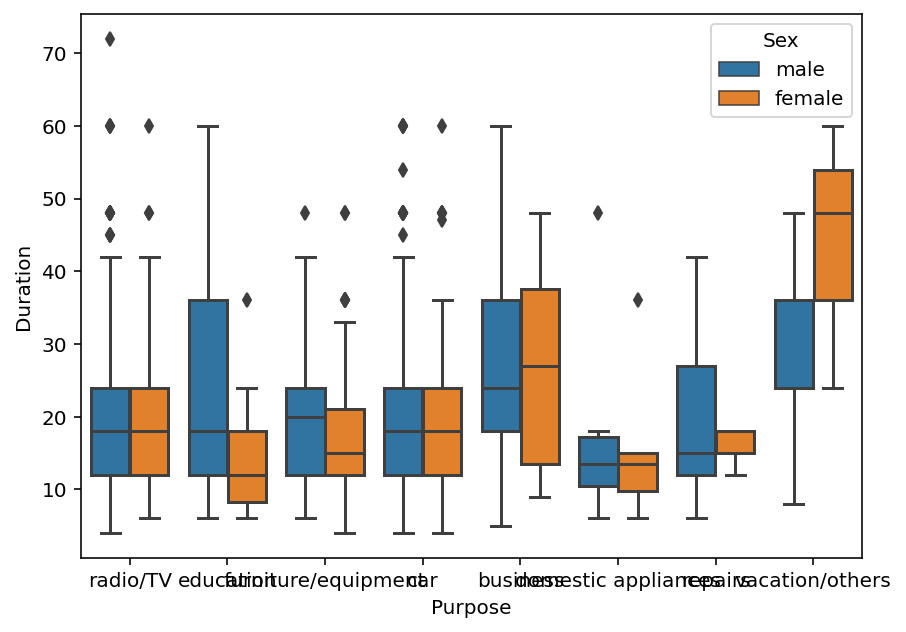

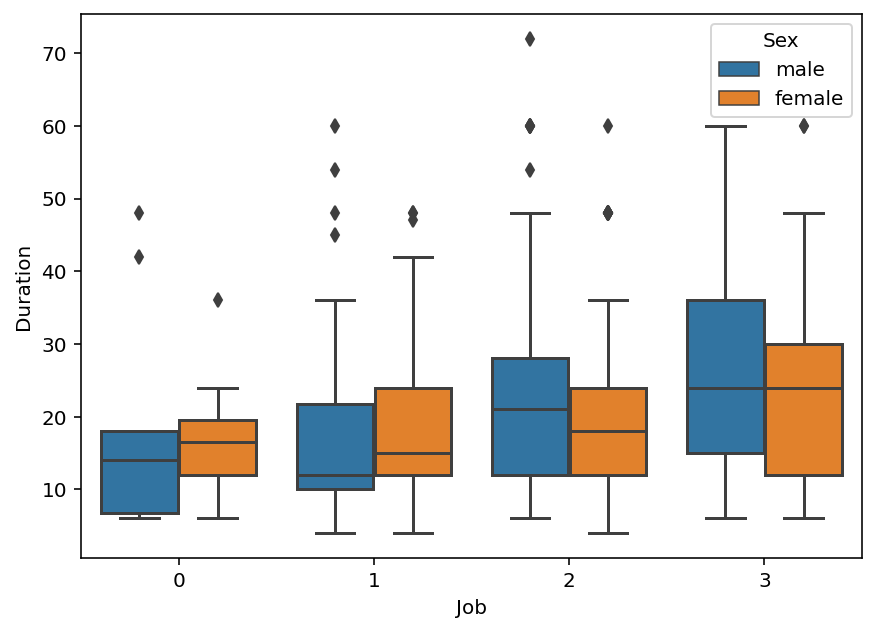

In [16]:
for col_a in continuous_cols:
    for col_d in category_cols:
        plt.figure(figsize=(7,5))
        sns.boxplot(x=col_d,y=col_a, hue="Sex", data=df)
        plt.show()

# 결측치 처리

In [17]:
df['Saving accounts'].value_counts()

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [18]:
df['Saving accounts'].fillna('No', inplace=True)
df['Saving accounts'].value_counts()

little        603
No            183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [19]:
df['Checking account'].fillna('No', inplace=True)
df['Checking account'].value_counts()

No          394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [21]:
df_clean = df.copy()

# 데이터 변환
- 카테고리 변환
- 로그변환
- 스케일링

## 카테고리 변수

In [22]:
category_cols

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Job']

In [23]:
df = pd.get_dummies(df, columns=category_cols)
df[:5]

,Age,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_No,Saving accounts_little,...,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Job_0,Job_1,Job_2,Job_3
0,67,1169,6,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,22,5951,48,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,49,2096,12,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,45,7882,42,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,53,4870,24,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 연속 변수
- 로그변환
- 스케일링

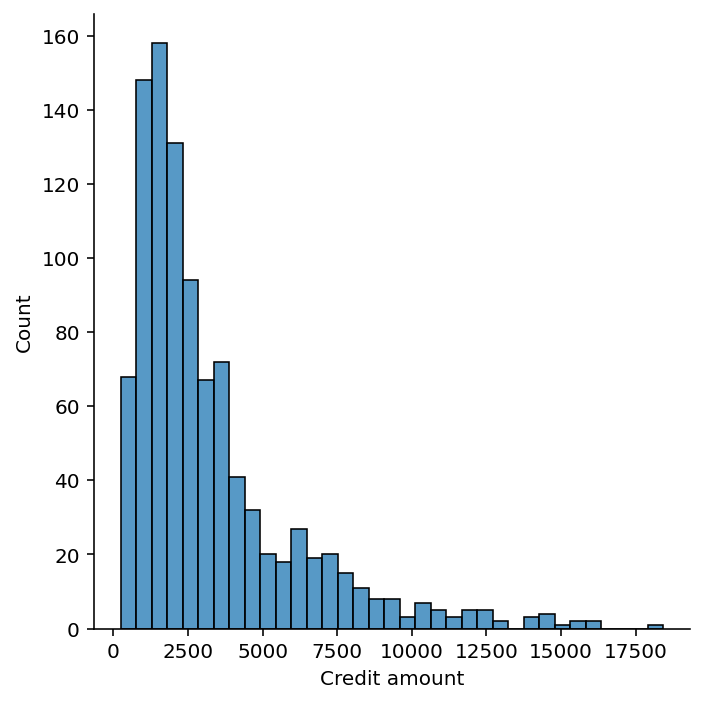

In [24]:
sns.displot(df['Credit amount'])

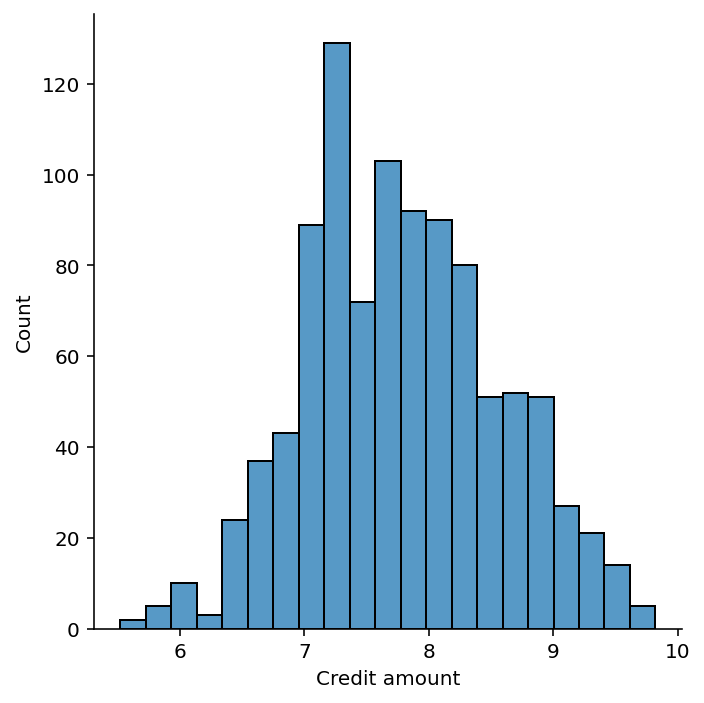

In [25]:
sns.displot(np.log(df['Credit amount']))

In [26]:
df['Credit amount'] = np.log(df['Credit amount'])
df[:5]

,Age,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_No,Saving accounts_little,...,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Job_0,Job_1,Job_2,Job_3
0,67,7.063904,6,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,22,8.691315,48,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,49,7.647786,12,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,45,8.972337,42,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,53,8.490849,24,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [27]:
df_sc = df.copy()

- 스케일링

In [28]:
df_sc.loc[:,continuous_cols] = StandardScaler().fit_transform(df[continuous_cols])

In [29]:
df_sc[:5]

,Age,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_No,Saving accounts_little,...,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Job_0,Job_1,Job_2,Job_3
0,2.766456,-0.933901,-1.236478,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,-1.191404,1.163046,2.248194,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,1.183312,-0.181559,-0.738668,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,0.831502,1.525148,1.750384,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,1.535122,0.904743,0.256953,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


# 클러스터링

- KMeans 사용

## 덴드로그램

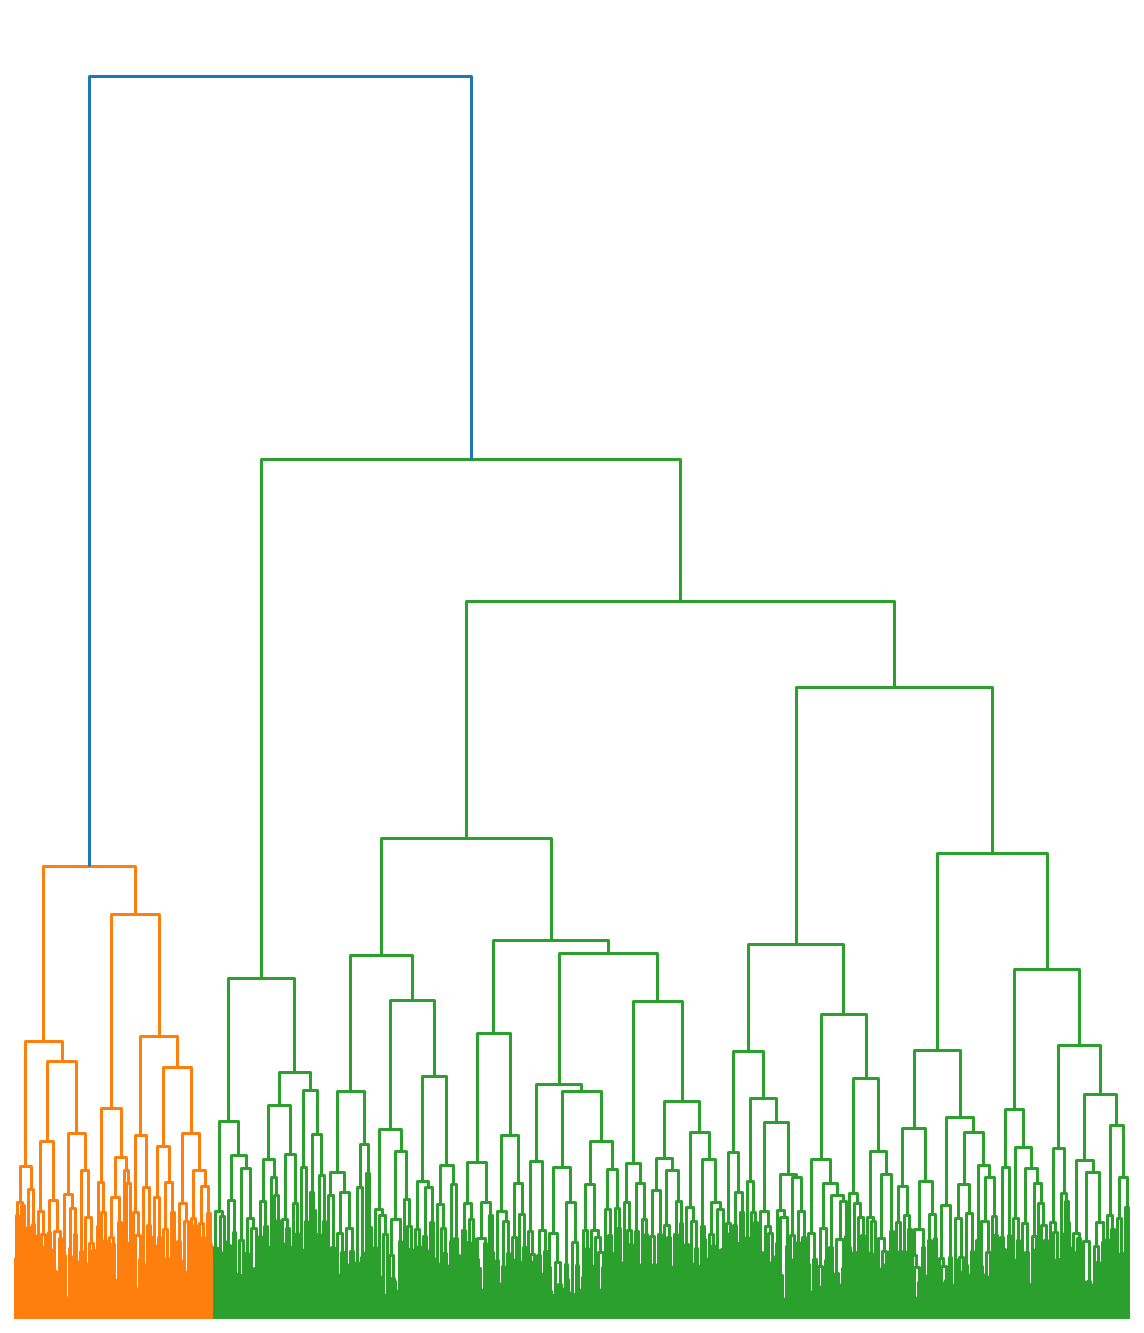

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 12))
link_dist = linkage(df_sc, method='ward')  
dendrogram(link_dist)
# dendrogram(link_dist, labels=df_sc.index.tolist())
plt.axis('off')
plt.show()

## inertia knee 포인트
- 클러스의 '무게'의 변화가 크게 변화하는 지점을 최적점으로 선택

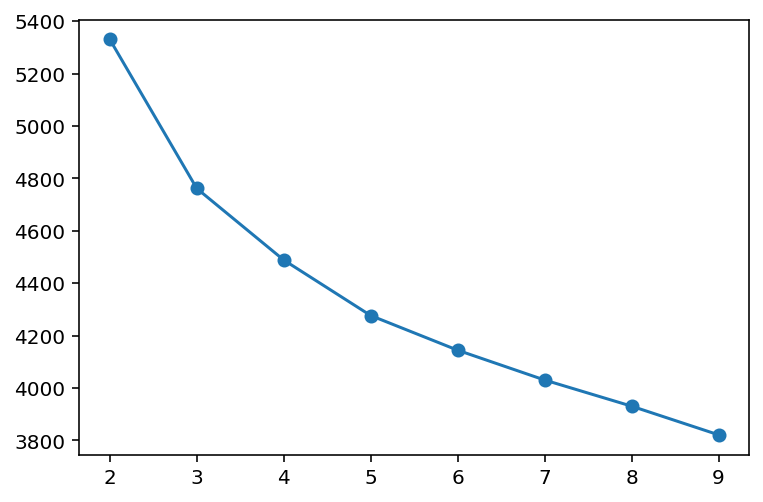

In [31]:
mass =[]

for c in range(2,10):
    kmeans = KMeans(c).fit(df_sc)
    mass.append(kmeans.inertia_)
plt.plot(range(2,10), mass, marker='o')

## 실루엣 지수

In [32]:
results =[]
for c in range(2,15):
  clusterer = KMeans(c)
  cluster_labels = clusterer.fit_predict(df_sc)
  silhouette_avg = silhouette_score(df_sc, cluster_labels)
  results.append([c,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","silhouette_score"])

<AxesSubplot:xlabel='n_clusters'>

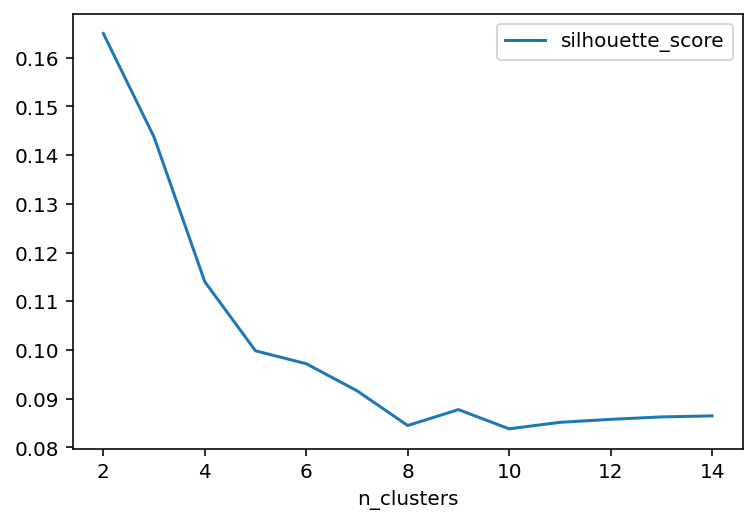

In [33]:
result.set_index('n_clusters').plot()

- 클러스터 수를 3으로 선택한다.

In [34]:
k = KMeans(3)
k.fit(df_sc)

KMeans(n_clusters=3)

In [35]:
df["cluster"] = k.labels_
df[:5]

,Age,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_No,Saving accounts_little,...,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Job_0,Job_1,Job_2,Job_3,cluster
0,67,7.063904,6,0,1,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,1
1,22,8.691315,48,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,2
2,49,7.647786,12,0,1,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,1
3,45,8.972337,42,0,1,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,2
4,53,8.490849,24,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1


## PCA 공간 스캐터플롯

In [36]:
def plot_pca(df, index, color, N=1000, show=False):
    pca = PCA(2)
    X = pca.fit_transform(df_sc)
    plt.figure(figsize=(8,8))
    plt.scatter(X[:,0][:N],X[:,1][:N], c= color[:N], s=20)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    if show:
        for n in range(N):
            plt.text(X[:,0][n], X[:,1][n], str(color[n])+str(index[n]))

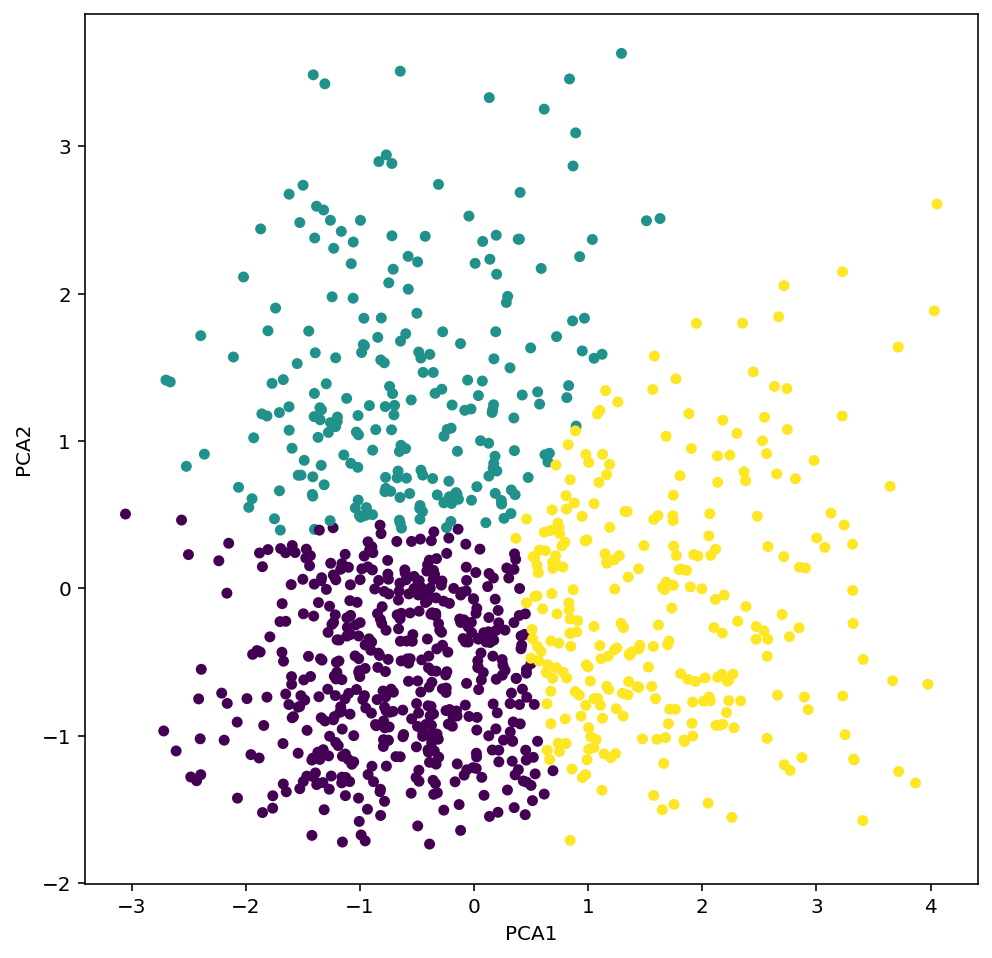

In [37]:
plot_pca(df_sc, index=df_sc.index, color=k.labels_, N=1000, show=False)

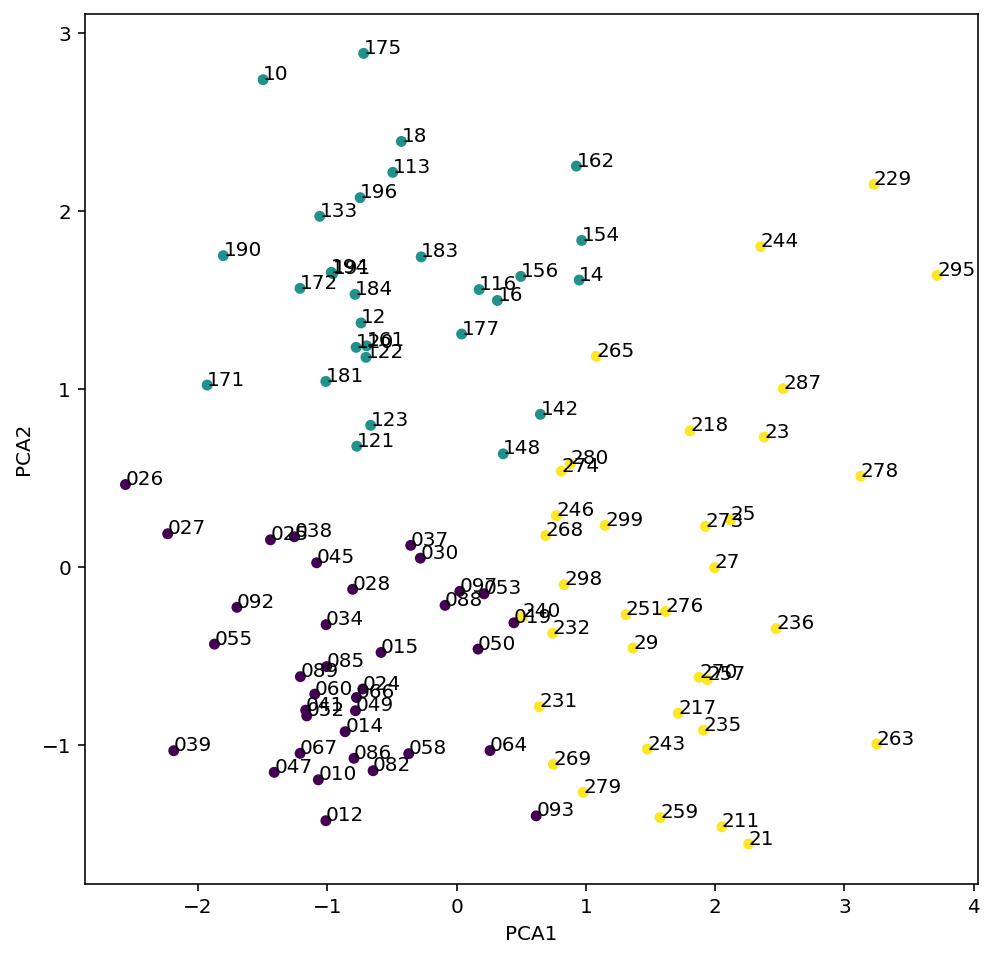

In [38]:
plot_pca(df_sc, index=df_sc.index, color=k.labels_, N=100, show=True)

In [39]:
df_clean.loc[[275, 163]]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
275,32,male,2,own,little,No,2697,9,radio/TV
163,70,male,3,free,little,moderate,7308,10,car


In [45]:
def plot_scatter(x,y,color, N=100):
    plt.figure(figsize=(6,6))
    plt.scatter(x[:N], y[:N], c= color[:N], s=20)

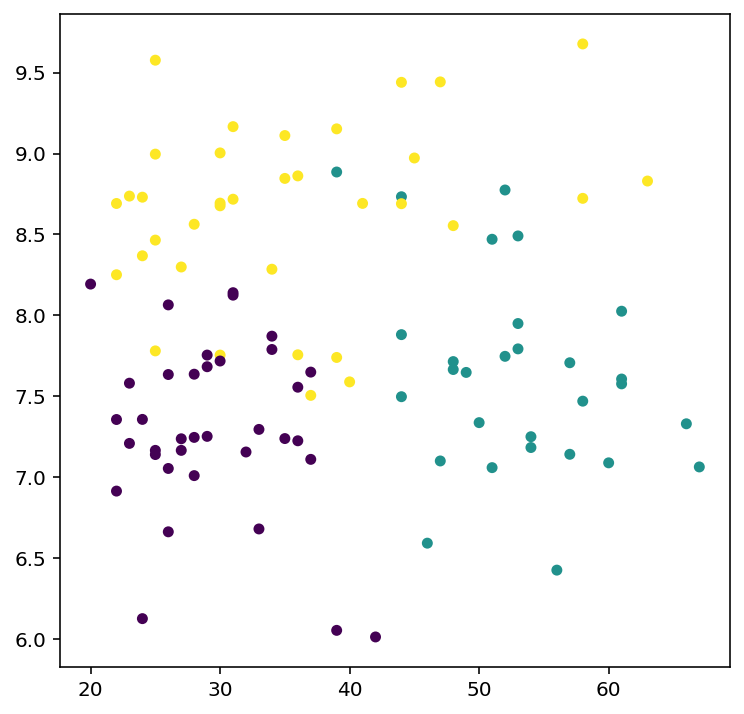

In [46]:
plot_scatter(df.Age, df['Credit amount'], color=k.labels_, N=100)

## 연속변수 공간 스캐터플롯

In [47]:
scatter_list = list(itertools.combinations(continuous_cols, 2))
scatter_list

[('Age', 'Credit amount'), ('Age', 'Duration'), ('Credit amount', 'Duration')]

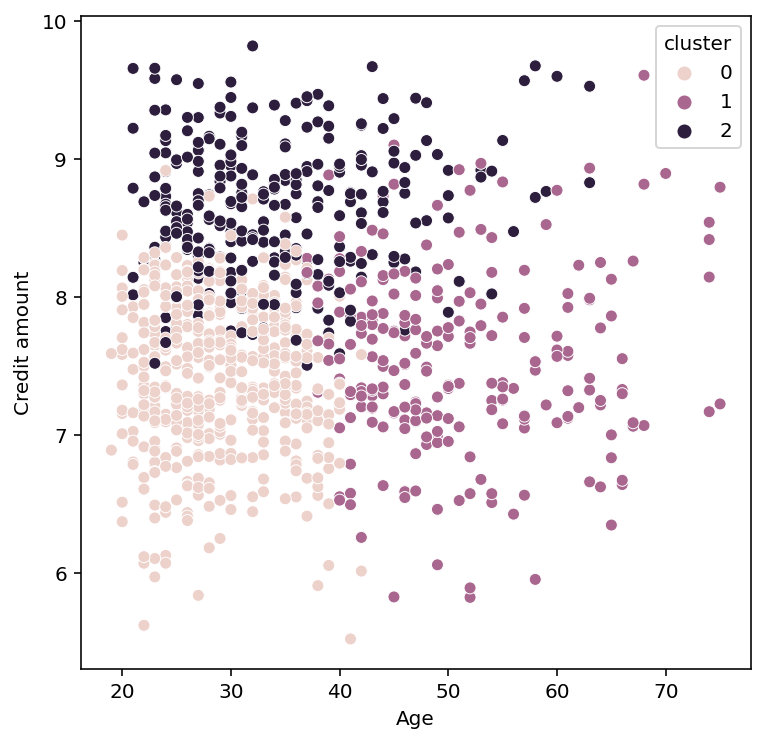

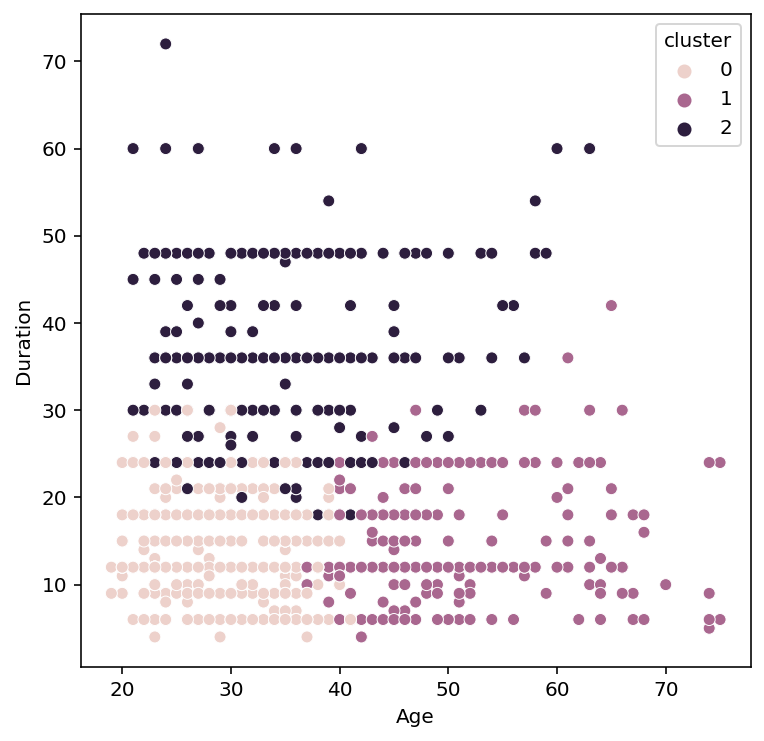

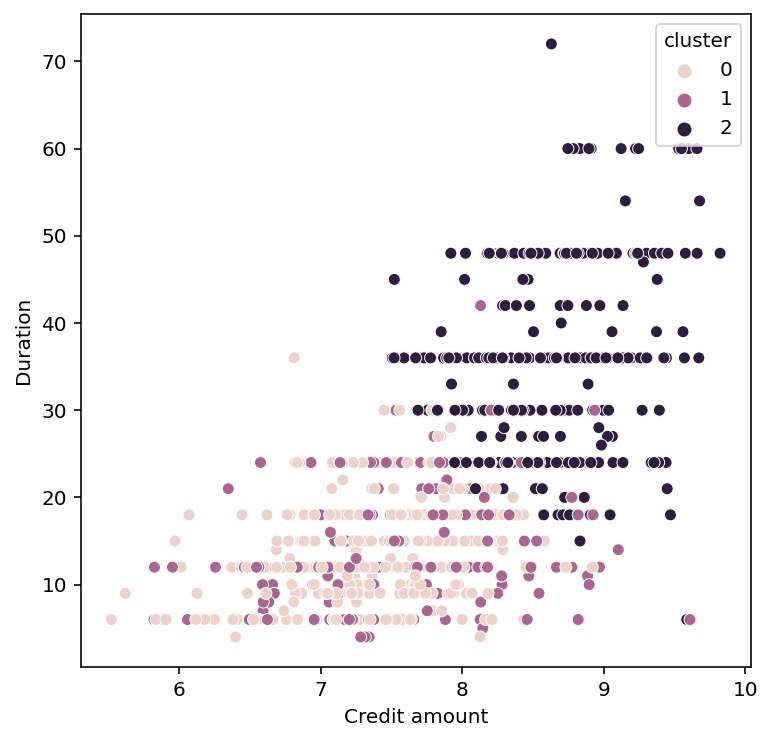

In [48]:
for pair in scatter_list:
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=df, x=pair[0],y=pair[1],hue='cluster')
    plt.show()

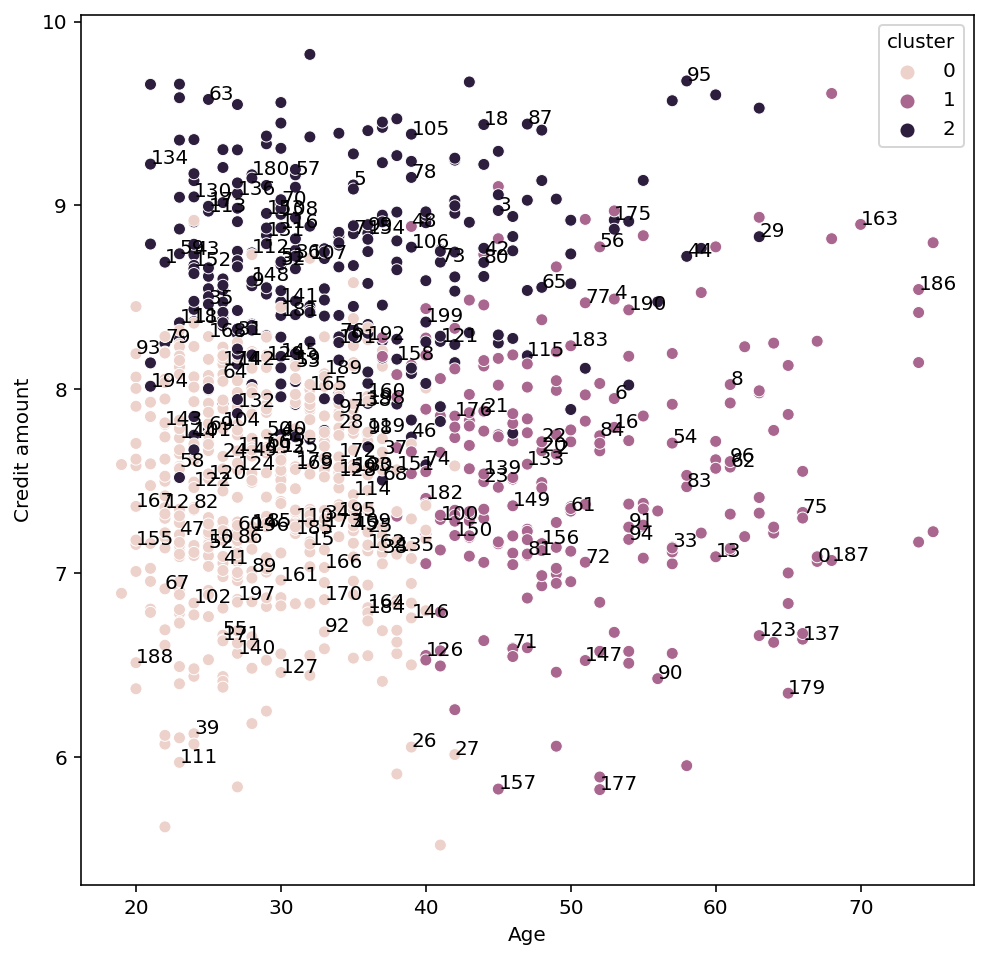

In [49]:
N=200
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x="Age", y="Credit amount", hue='cluster')
for n in range(N):
    plt.text(df.Age[n], df['Credit amount'][n], str(df.index[n]))